#Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud

In [2]:
marketing_campaign_df = pd.read_csv('./marketing_campaign.csv')

In [3]:
marketing_campaign_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


#Knowing Data

In [4]:
def attribute_information(df):
  info = dict()
  info_df = pd.DataFrame(columns=['Attribute_Name','Range','Min','Max','Mean','Median','Mode','Outlier_Range','Std'])
  for column in df.columns:
    if df[column].dtype.kind in 'iufc':
      Q1, median, Q3 = df[column].quantile([0.25, 0.5, 0.75])
      IQR = Q3-Q1
      info['Attribute_Name'] = column
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      info['Range'] = []
      info['Min'] = df[column].min()
      info['Max'] = df[column].max()
      info['Mean'] = df[column].mean()
      info['Median'] = median
      info['Mode'] = df[column].mode().tolist()
      info['Outlier_Range'] = []
      if lower_bound > info['Min']:
        info['Outlier_Range'].append([info['Min'],lower_bound])
        info['Range'].append(lower_bound)
      else:
        info['Range'].append(info['Min'])
      if upper_bound < info['Max']:
        info['Outlier_Range'].append([upper_bound, info['Max']])
        info['Range'].append(upper_bound)
      else:
        info['Range'].append(info['Max'])
      info['Std'] = df[column].std()
      df_dictionary = pd.DataFrame([info])
      info_df = pd.concat([info_df, df_dictionary], ignore_index=True)

  info_df.to_csv('./attributes_information.csv', )

In [5]:
attribute_information(marketing_campaign_df)

#Draw Box Plot

In [6]:
from genericpath import isdir
def drwa_box_plot(df):
  if not os.path.isdir('./box_plot'):
    os.mkdir('./box_plot')
  for column in df.columns:
    if df[column].dtype.kind in 'iufc':
      plt.figure(figsize=(5,5))
      df.boxplot([column])
      plt.savefig('./box_plot/'+column+'_boxplot.png')

<ipython-input-6-b8fcf7ab4ef8>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


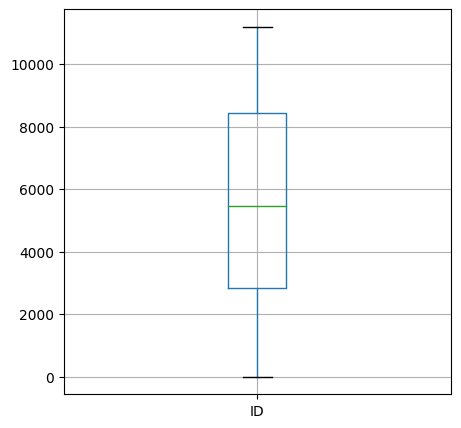

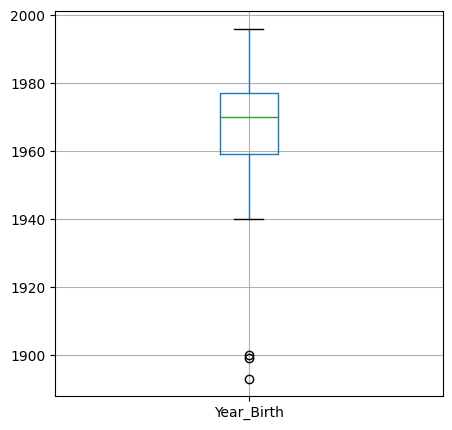

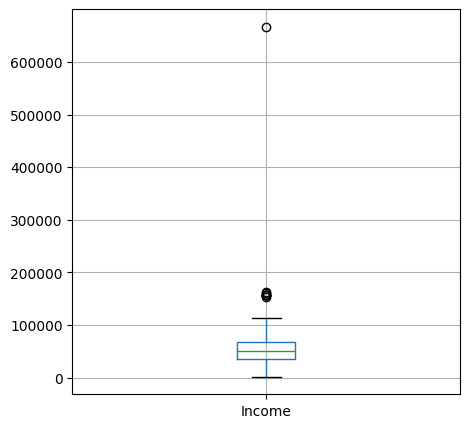

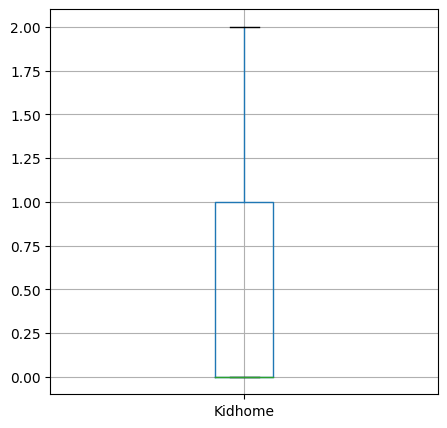

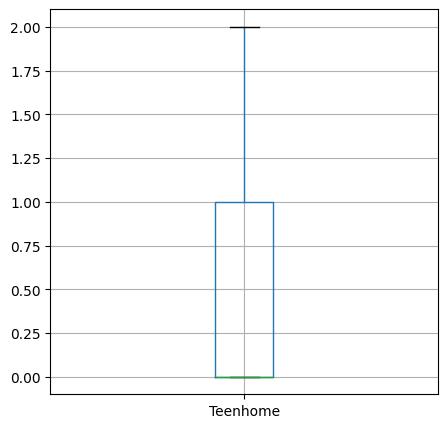

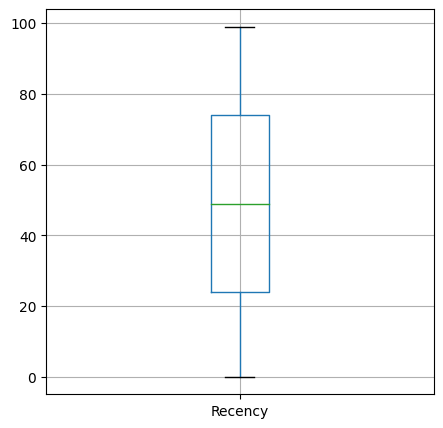

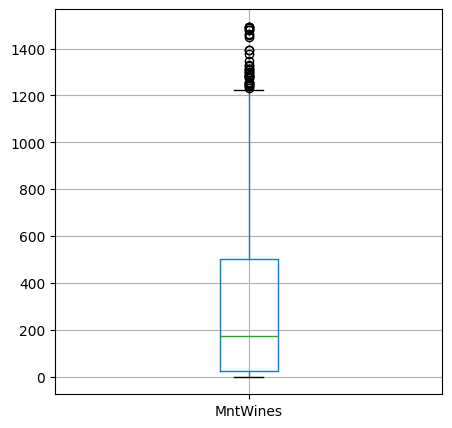

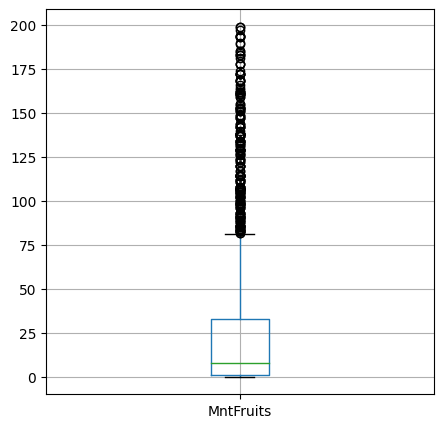

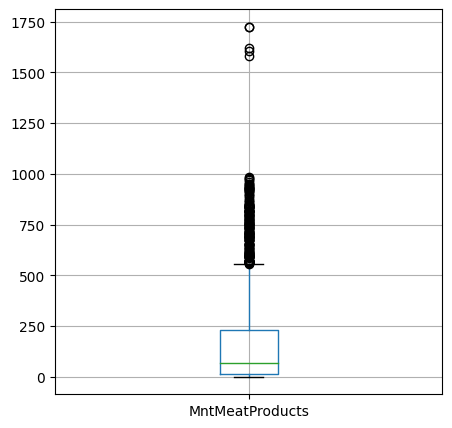

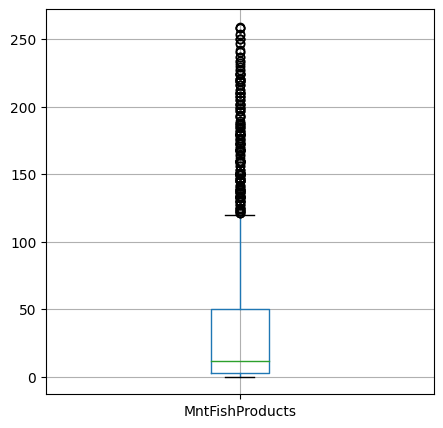

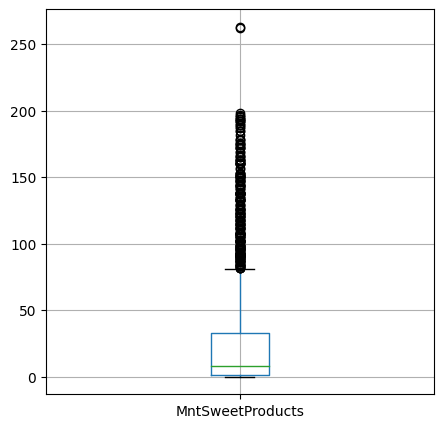

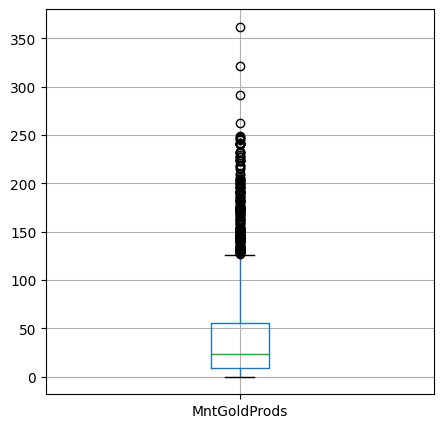

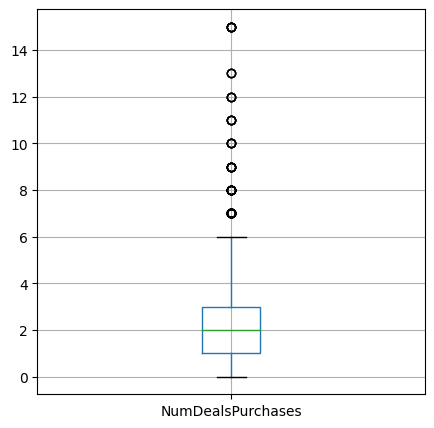

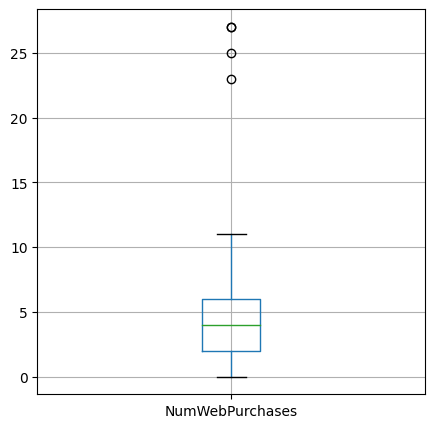

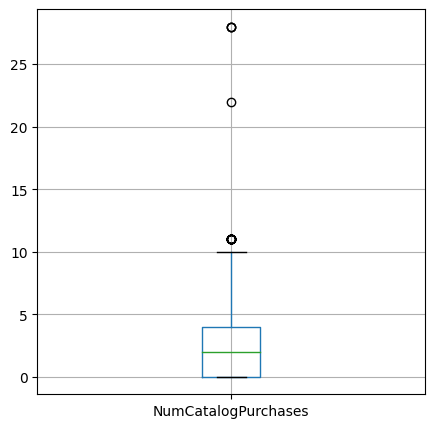

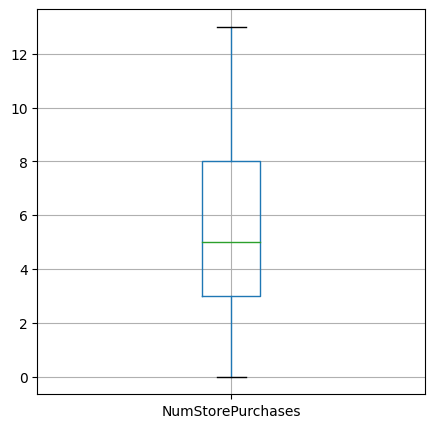

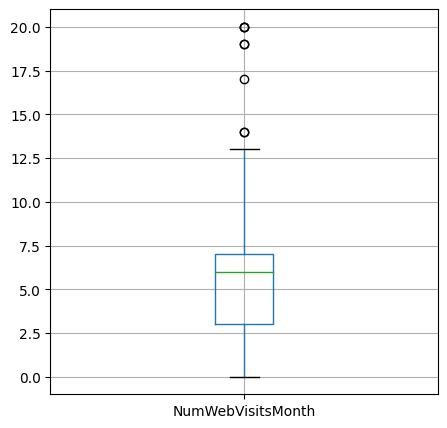

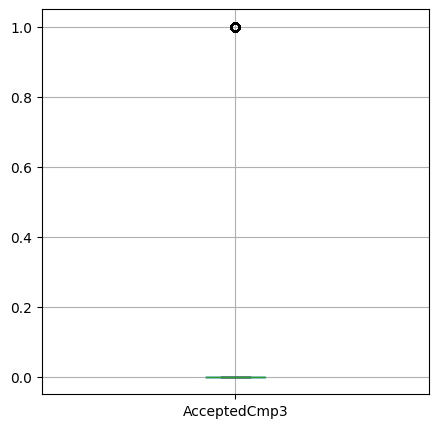

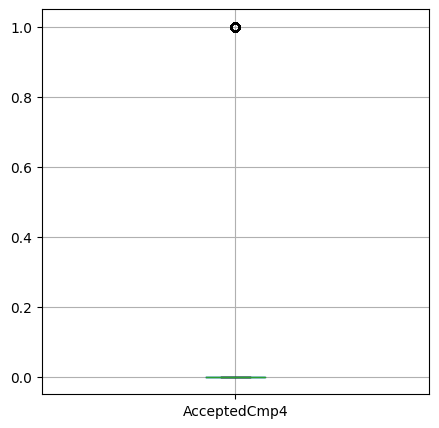

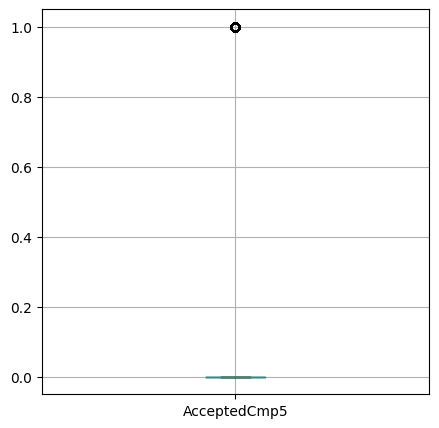

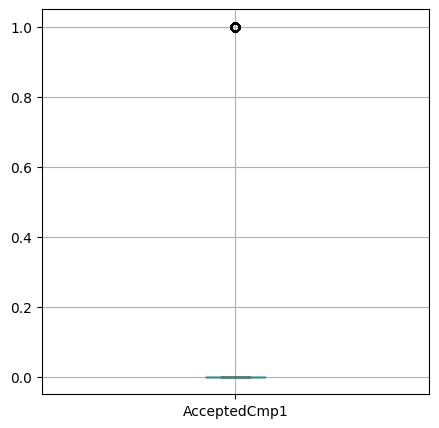

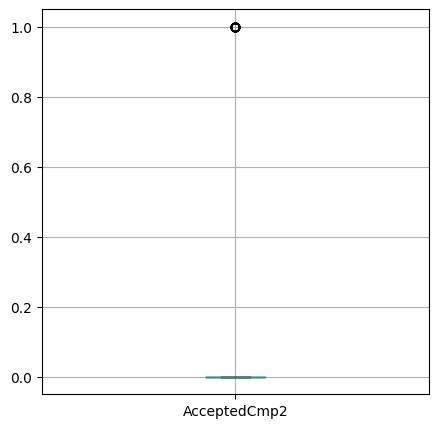

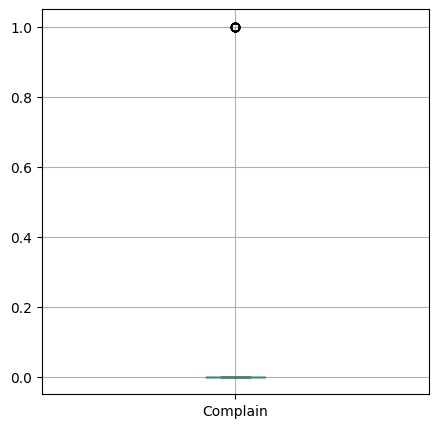

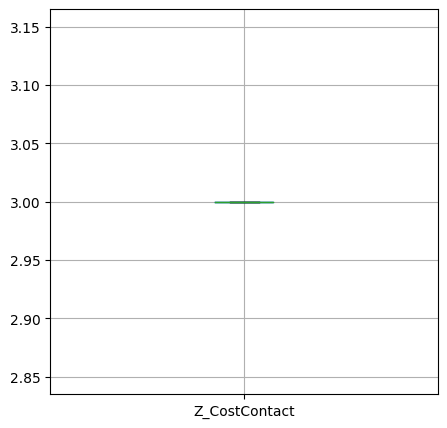

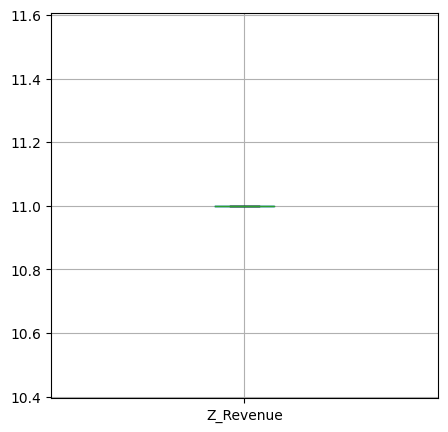

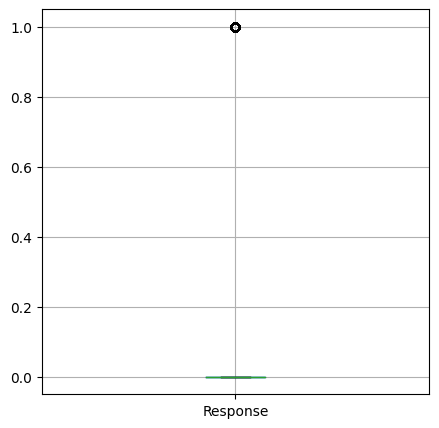

In [7]:
drwa_box_plot(marketing_campaign_df)

# Check Validity of Columns

In [8]:
marketing_campaign_df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [9]:
def dtype_mapping(df):
  dtype_map = {'int64': 'int32', 'float64': 'float32'}
  for column_name in df.columns:
      if df[column_name].dtype.name in dtype_map:
        df[column_name] = df[column_name].astype(dtype_map[df[column_name].dtype.name])
      elif df[column_name].dtype.name == 'object':
        try:
            df[column_name] = pd.to_datetime(df[column_name])
        except ValueError:
            pass
  return df

In [10]:
marketing_campaign_df = dtype_mapping(marketing_campaign_df)

In [11]:
marketing_campaign_df.dtypes

ID                              int32
Year_Birth                      int32
Education                      object
Marital_Status                 object
Income                        float32
Kidhome                         int32
Teenhome                        int32
Dt_Customer            datetime64[ns]
Recency                         int32
MntWines                        int32
MntFruits                       int32
MntMeatProducts                 int32
MntFishProducts                 int32
MntSweetProducts                int32
MntGoldProds                    int32
NumDealsPurchases               int32
NumWebPurchases                 int32
NumCatalogPurchases             int32
NumStorePurchases               int32
NumWebVisitsMonth               int32
AcceptedCmp3                    int32
AcceptedCmp4                    int32
AcceptedCmp5                    int32
AcceptedCmp1                    int32
AcceptedCmp2                    int32
Complain                        int32
Z_CostContac

In [12]:
marketing_campaign_df['ID'].is_unique

True

In [13]:
marketing_campaign_df['Year_Birth'].min(), marketing_campaign_df['Year_Birth'].max()

(1893, 1996)

In [14]:
marketing_campaign_df['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [15]:
marketing_campaign_df['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [16]:
marketing_campaign_df['Marital_Status'].value_counts()

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [17]:
values_to_remove = ['Alone', 'Absurd', 'YOLO']
marketing_campaign_df = marketing_campaign_df[~marketing_campaign_df['Marital_Status'].isin(values_to_remove)]
marketing_campaign_df['Marital_Status'].value_counts()

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Name: Marital_Status, dtype: int64

In [18]:
avg = marketing_campaign_df['Income'].mean()
marketing_campaign_df['Income'] = marketing_campaign_df['Income'].fillna(avg)
marketing_campaign_df.isnull().sum()

<ipython-input-18-d50d2c8b0021>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marketing_campaign_df['Income'] = marketing_campaign_df['Income'].fillna(avg)


ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

In [19]:
col_check = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response']
for col in col_check:
  print(col)
  print(marketing_campaign_df[col].value_counts())
  print('_______________________________________________')

AcceptedCmp1
0    2090
1     143
Name: AcceptedCmp1, dtype: int64
_______________________________________________
AcceptedCmp2
0    2203
1      30
Name: AcceptedCmp2, dtype: int64
_______________________________________________
AcceptedCmp3
0    2071
1     162
Name: AcceptedCmp3, dtype: int64
_______________________________________________
AcceptedCmp4
0    2066
1     167
Name: AcceptedCmp4, dtype: int64
_______________________________________________
AcceptedCmp5
0    2071
1     162
Name: AcceptedCmp5, dtype: int64
_______________________________________________
Response
0    1902
1     331
Name: Response, dtype: int64
_______________________________________________


## Remove Outliers

In [20]:
import numpy as np

# Select numeric columns for outlier removal
numeric_columns = marketing_campaign_df.select_dtypes(include=np.number).columns

# Calculate the IQR for each numeric column
Q1 = marketing_campaign_df[numeric_columns].quantile(0.25)
Q3 = marketing_campaign_df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of rows before removing outliers
num_rows_before = len(marketing_campaign_df)

# Remove outliers from the dataset
marketing_campaign_df = marketing_campaign_df[~((marketing_campaign_df[numeric_columns] < lower_bound) | (marketing_campaign_df[numeric_columns] > upper_bound)).any(axis=1)]

# Count the number of rows after removing outliers
num_rows_after = len(marketing_campaign_df)

# Print the number of rows before and after removing outliers
print("Number of rows before removing outliers:", num_rows_before)
print("Number of rows after removing outliers:", num_rows_after)


Number of rows before removing outliers: 2233
Number of rows after removing outliers: 1205


# EDA Analysis

#### The abundance of customer education with the word cloud method

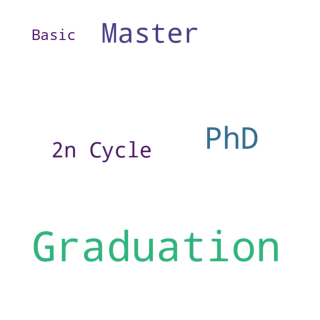

In [21]:
words_list = marketing_campaign_df['Education'].tolist()
# join the list of words into a string
words_string = ' '.join(words_list)

# create the word cloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(words_string)

# plot the word cloud
plt.figure(figsize = (3, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#### What year did the most customer registered in the company?

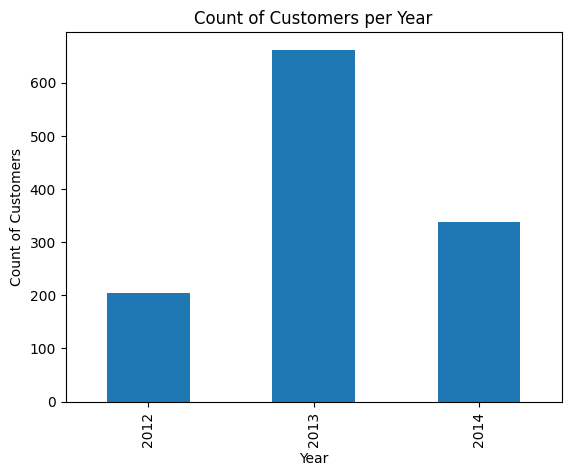

In [22]:
ax = marketing_campaign_df.groupby(marketing_campaign_df['Dt_Customer'].dt.year).count()['Dt_Customer'].plot(kind='bar')
ax.set_xlabel("Year")
ax.set_ylabel("Count of Customers")
ax.set_title("Count of Customers per Year")
plt.show()

#### What kind of products did the customers buy the most in the past two years?

In [23]:
total_wine = marketing_campaign_df['MntWines'].sum()
total_fruit = marketing_campaign_df['MntFruits'].sum()
total_meat = marketing_campaign_df['MntMeatProducts'].sum()
total_fish = marketing_campaign_df['MntFishProducts'].sum()
total_sweet = marketing_campaign_df['MntSweetProducts'].sum()
total_gold = marketing_campaign_df['MntGoldProds'].sum()

In [24]:
[total_wine, total_fruit, total_meat, total_fish, total_sweet, total_gold]

[172613, 11861, 73399, 17345, 11923, 26520]

In [25]:
np.array([total_wine, total_fruit, total_meat, total_fish, total_sweet, total_gold]).argmax()

0

In [26]:
marketing_campaign_df['TotalMnt'] = total_wine = marketing_campaign_df['MntWines'] + marketing_campaign_df['MntFruits'] + marketing_campaign_df['MntMeatProducts'] + marketing_campaign_df['MntFishProducts'] + marketing_campaign_df['MntSweetProducts'] + marketing_campaign_df['MntGoldProds']

#### The impact of education on the amount consumed in the past two years

<Axes: xlabel='Education', ylabel='TotalMnt'>

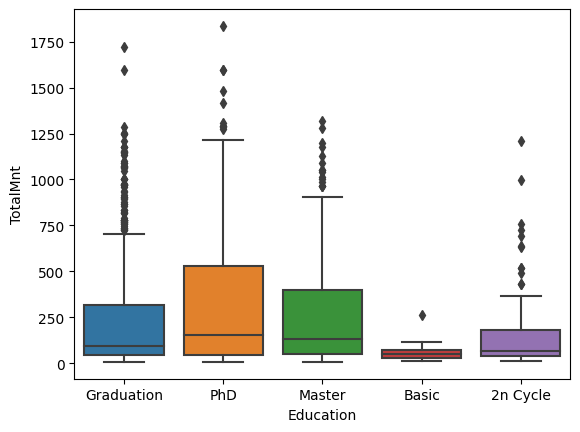

In [27]:
import seaborn as sns
sns.boxplot(x='Education', y='TotalMnt', data=marketing_campaign_df)

<Axes: xlabel='Education', ylabel='TotalMnt'>

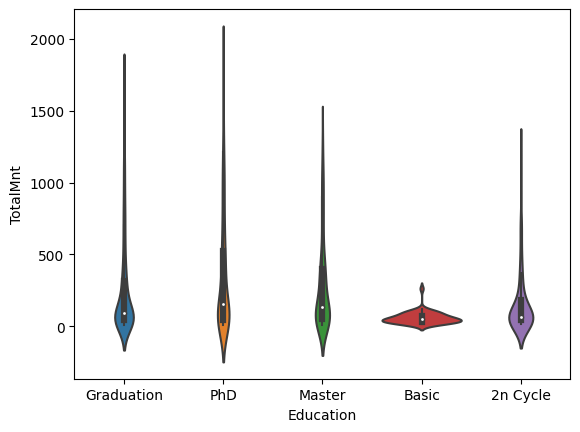

In [28]:
sns.violinplot(x='Education', y='TotalMnt', data=marketing_campaign_df)

#### Correlation between Income and amount consumed in the past two years

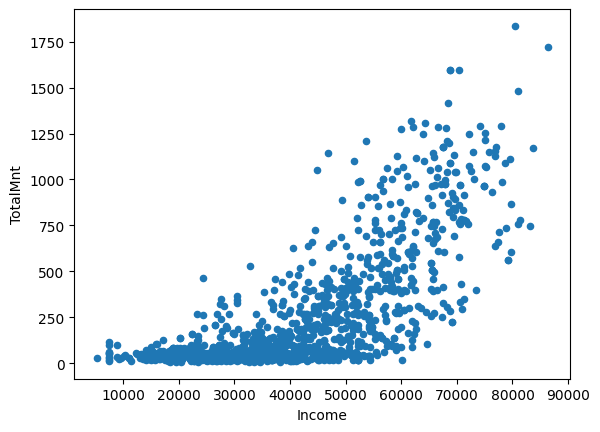

In [29]:
marketing_campaign_df.plot.scatter(x='Income', y='TotalMnt')
plt.show()

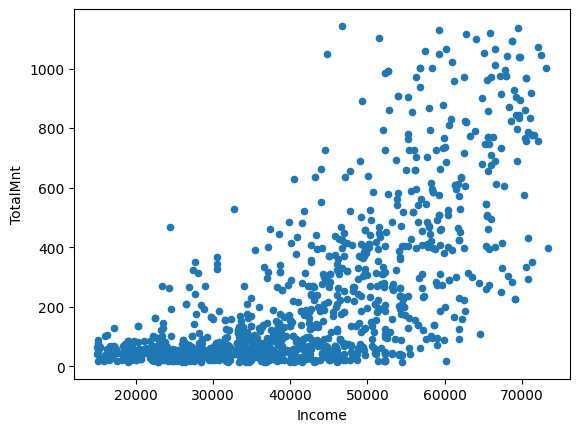

In [30]:
data = marketing_campaign_df[['Income','TotalMnt']]
quantiles = data.quantile([0.025, 0.975])
# Filter out any rows with values outside the 95th percentile
filtered_data = data[(data >= quantiles.loc[0.025]) & (data <= quantiles.loc[0.975])]
filtered_data.plot.scatter(x='Income', y='TotalMnt')
plt.show()

In [31]:
correlation = marketing_campaign_df["Income"].corr(marketing_campaign_df["TotalMnt"])
print("Correlation between income and total_amount:", correlation)

Correlation between income and total_amount: 0.7296820217047701


#### The relationship between education level and attraction to different campaigns

In [32]:
marketing_campaign_df['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

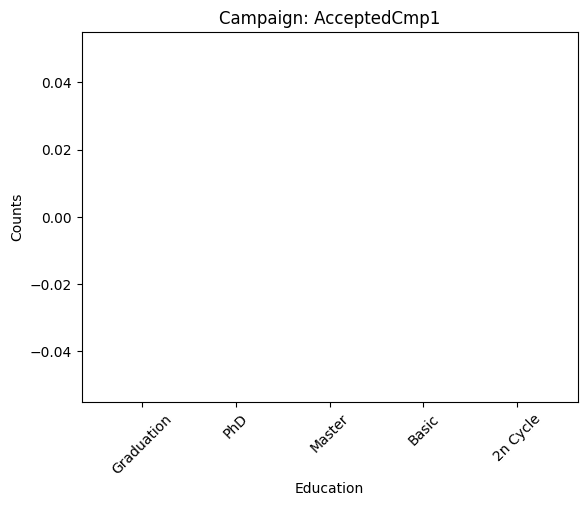

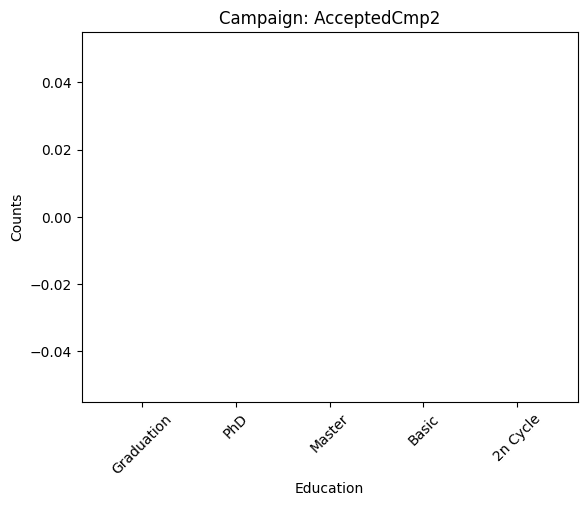

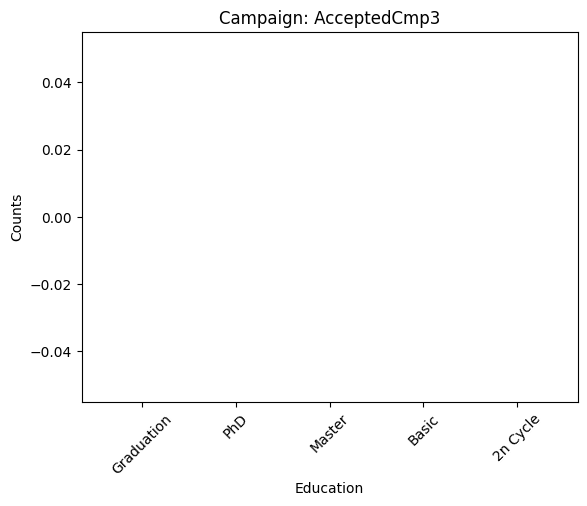

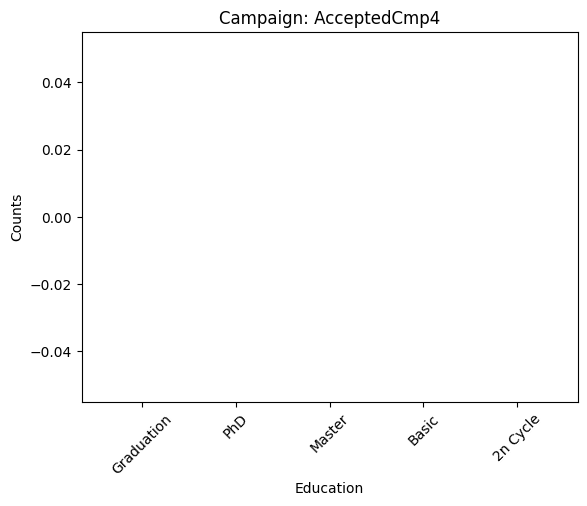

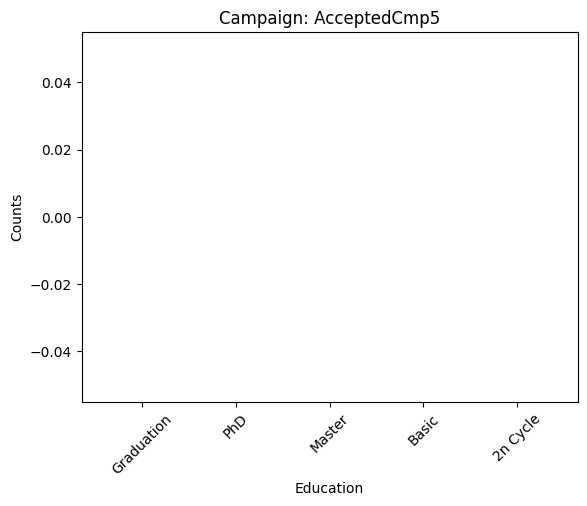

In [33]:
campaign_list = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
for campaign in campaign_list:
  education = dict({
      'Graduation': 0,
      'PhD': 0,
      'Master':0,
      'Basic':0,
      '2n Cycle':0
  })
  for key in education.keys():
    education[key] = marketing_campaign_df[(marketing_campaign_df['Education'] == key) & (marketing_campaign_df[campaign])].shape[0]
  plt.bar(education.keys(), education.values())
  plt.xlabel('Education')
  plt.ylabel('Counts')
  plt.title(f'Campaign: {campaign}')
  plt.xticks(rotation=45)
  plt.show()

The relationship between age and attraction to different campaigns

In [34]:
marketing_campaign_df['Age'] = 2014 - marketing_campaign_df['Year_Birth']

In [35]:
marketing_campaign_df['Age'].min(), marketing_campaign_df['Age'].max()

(19, 74)

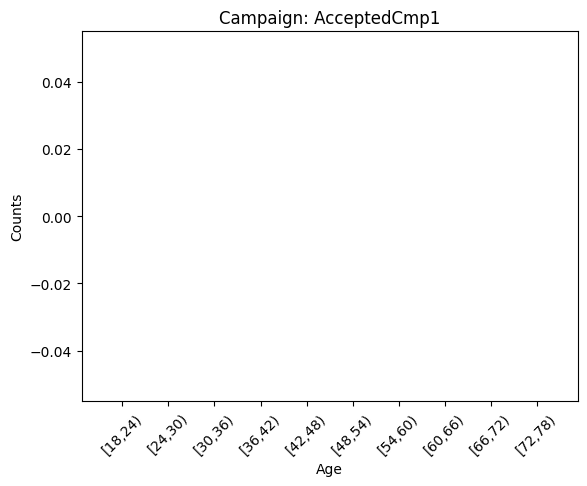

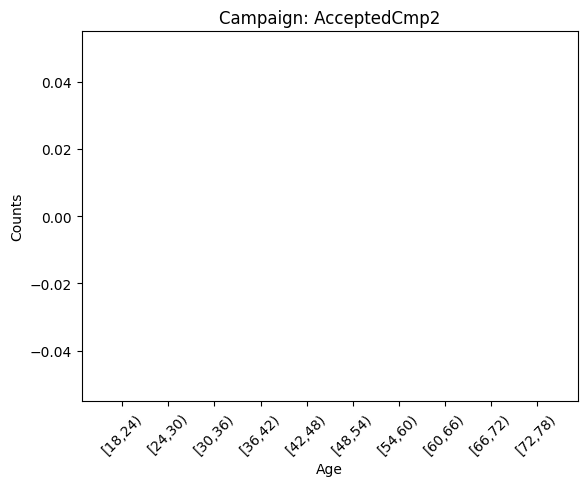

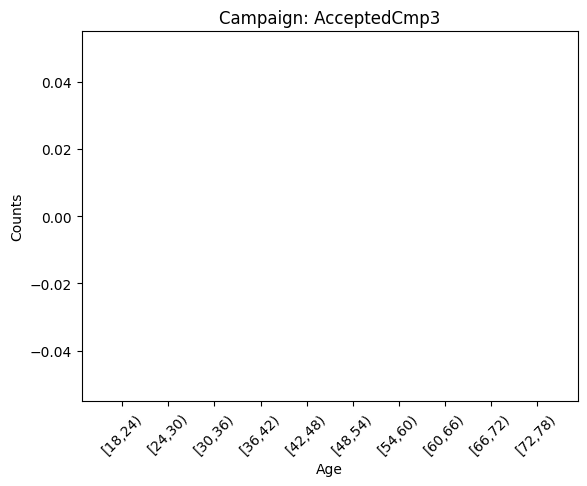

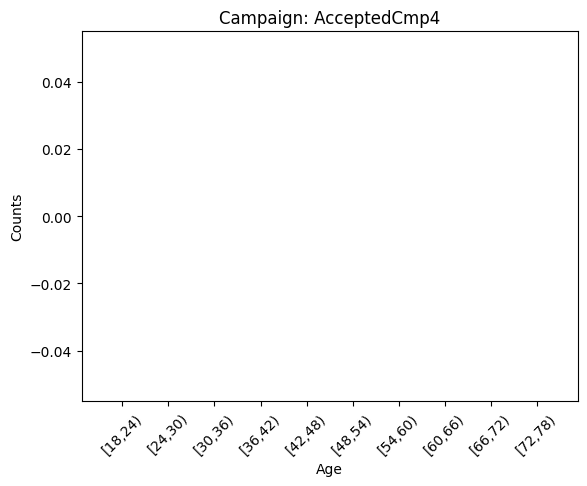

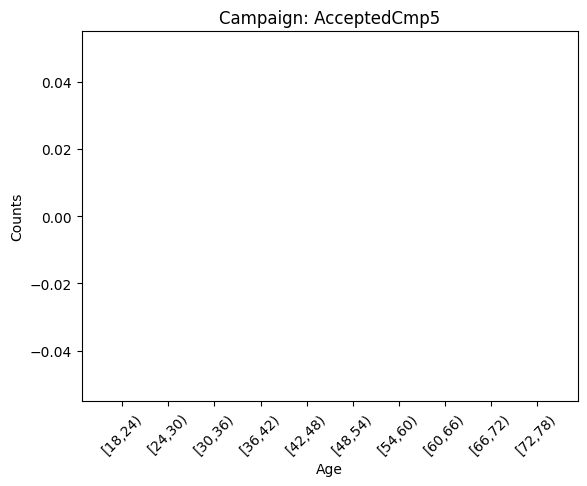

In [36]:
for campaign in campaign_list:
  lower_bound = 18
  bin_size = 6
  age_count = dict()
  while lower_bound < marketing_campaign_df['Age'].max():
    upper_bound = lower_bound + bin_size
    age_count['['+str(lower_bound)+','+str(upper_bound)+')'] = marketing_campaign_df[(marketing_campaign_df['Age'] >= lower_bound) & (marketing_campaign_df['Age'] < upper_bound) & (marketing_campaign_df[campaign])].shape[0]
    lower_bound = upper_bound

  plt.bar(age_count.keys(), age_count.values())
  plt.xlabel('Age')
  plt.ylabel('Counts')
  plt.title(f'Campaign: {campaign}')
  plt.xticks(rotation=45)
  plt.show()

#### Correlation between the level of income and the purchase of each of the available items

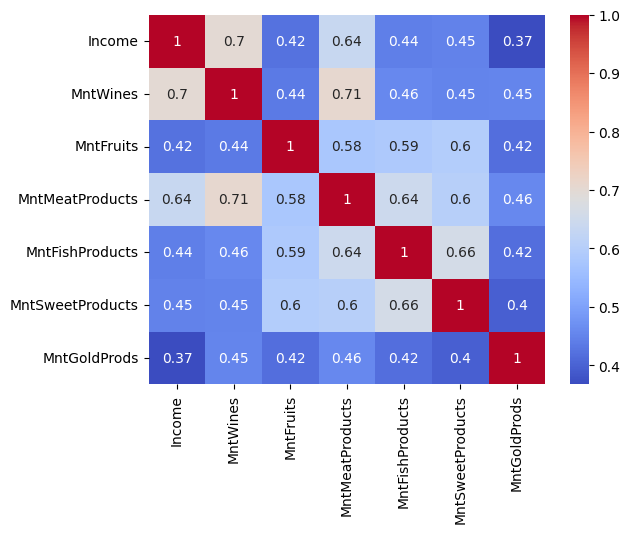

In [37]:
columns = ['Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
corr_matrix = marketing_campaign_df[columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

<Axes: xlabel='Marital_Status', ylabel='TotalMnt'>

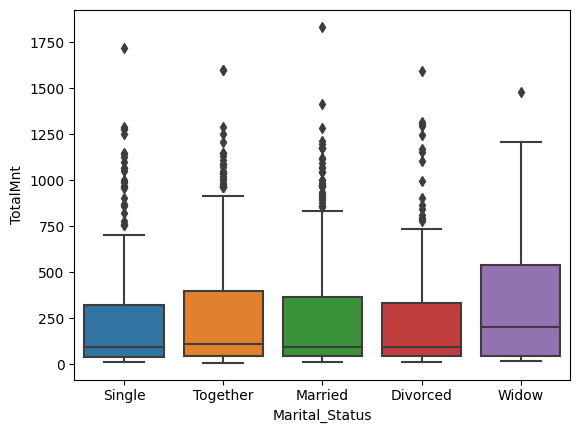

In [38]:
sns.boxplot(x='Marital_Status', y='TotalMnt', data=marketing_campaign_df)

<Axes: xlabel='Marital_Status', ylabel='TotalMnt'>

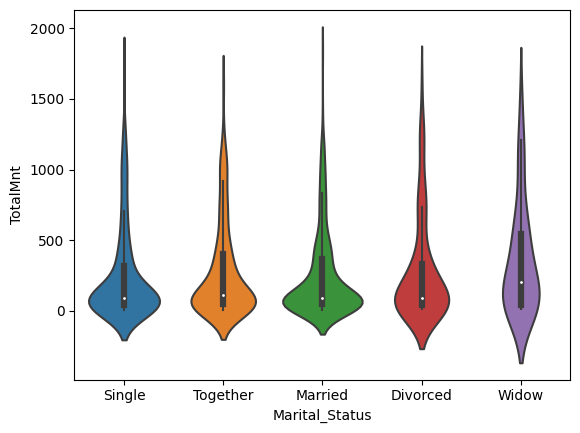

In [39]:
sns.violinplot(x='Marital_Status', y='TotalMnt', data=marketing_campaign_df)

Relatio between time and recency and between time and Number of Store Purchases

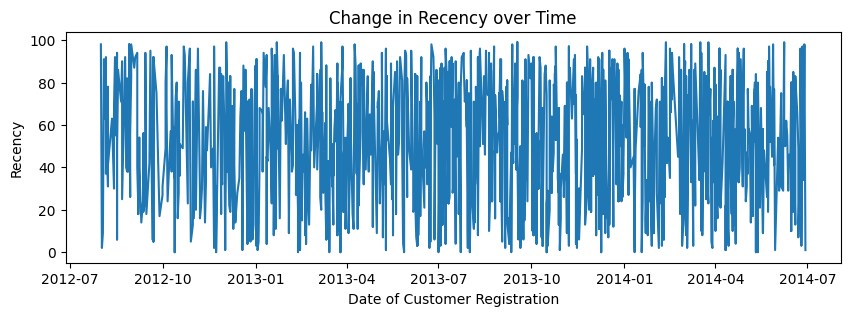

In [40]:
df_sorted = marketing_campaign_df.sort_values('Dt_Customer')
plt.figure(figsize = (10, 3))
plt.plot(df_sorted['Dt_Customer'], df_sorted['Recency'])
plt.xlabel('Date of Customer Registration')
plt.ylabel('Recency')
plt.title('Change in Recency over Time')
plt.show()

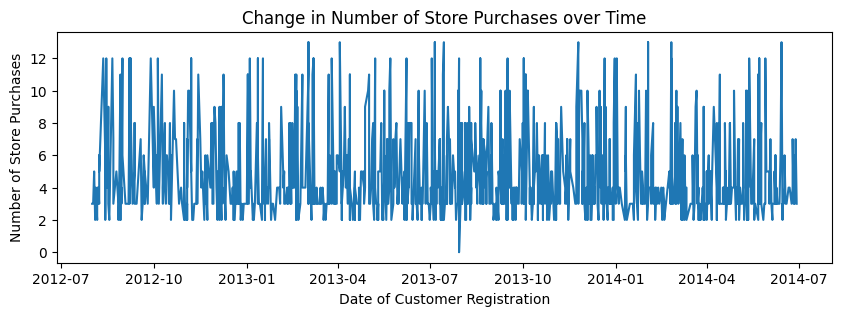

In [41]:
plt.figure(figsize = (10, 3))
plt.plot(df_sorted['Dt_Customer'], df_sorted['NumStorePurchases'])
plt.xlabel('Date of Customer Registration')
plt.ylabel('Number of Store Purchases')
plt.title('Change in Number of Store Purchases over Time')
plt.show()

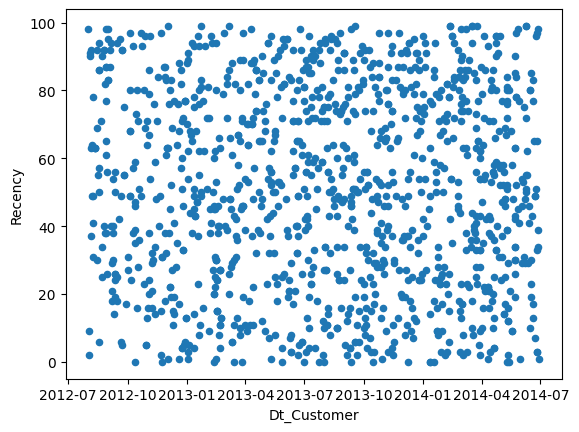

In [42]:
marketing_campaign_df.plot.scatter(x='Dt_Customer', y='Recency')
plt.show()

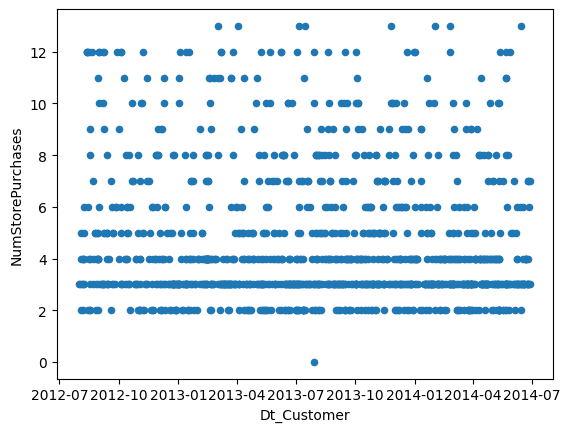

In [43]:
marketing_campaign_df.plot.scatter(x='Dt_Customer', y='NumStorePurchases')
plt.show()

# Pattern analysis and presentation of prediction models

## Unsupervised Learning

### Clustering on age and total spending

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


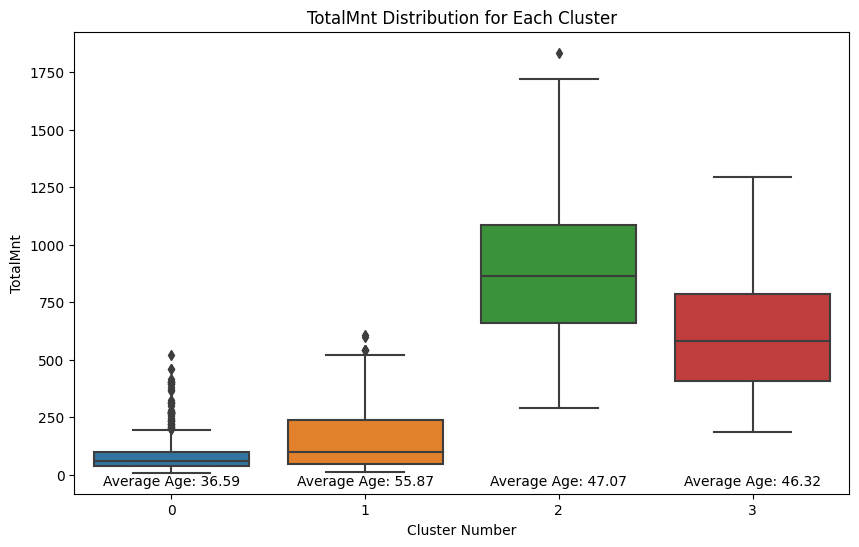

In [45]:
# age_threshold = 60
# income_threshold = 500
# expenses_threshold = 500
relevant_columns = ['Age', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'TotalMnt']
data = marketing_campaign_df.copy()[relevant_columns]
marketing_campaign_df['Cluster'] = np.nan
# Preprocess the data by normalizing
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data[relevant_columns])

# Perform clustering with K-means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_normalized)
marketing_campaign_df['Cluster'] = kmeans.labels_

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='TotalMnt', data=marketing_campaign_df)
plt.xlabel('Cluster Number')
plt.ylabel('TotalMnt')
plt.title('TotalMnt Distribution for Each Cluster')

average_age_per_cluster = marketing_campaign_df.groupby('Cluster')['Age'].mean()
for i, avg_age in average_age_per_cluster.items():
    plt.text(i, 0, f"Average Age: {avg_age:.2f}", ha='center', va='top')

plt.show()

In [46]:
from sklearn.metrics import silhouette_score

# Calculate the Silhouette coefficient for the clustering results
silhouette_avg = silhouette_score(data_normalized, kmeans.labels_)

print(f"Silhouette coefficient: {silhouette_avg}")

Silhouette coefficient: 0.29252261935110724


### Clustering on each item product

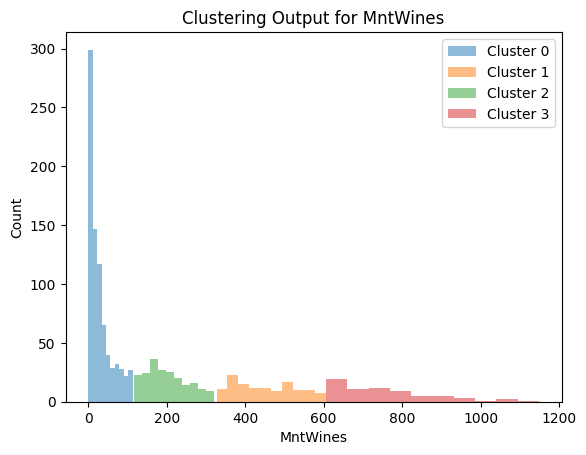

Silhouette coefficient for MntWines: 0.7168871138545135



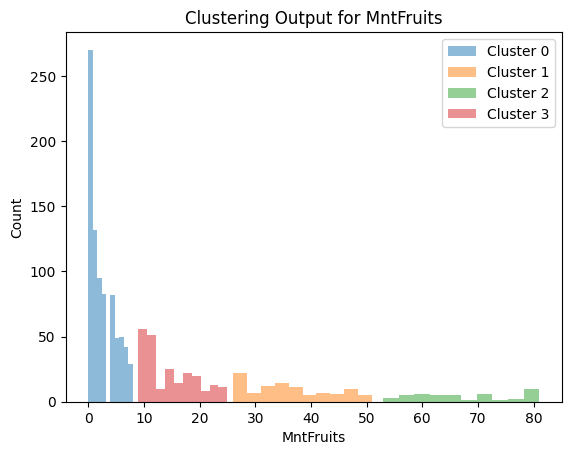

Silhouette coefficient for MntFruits: 0.6832974624371608



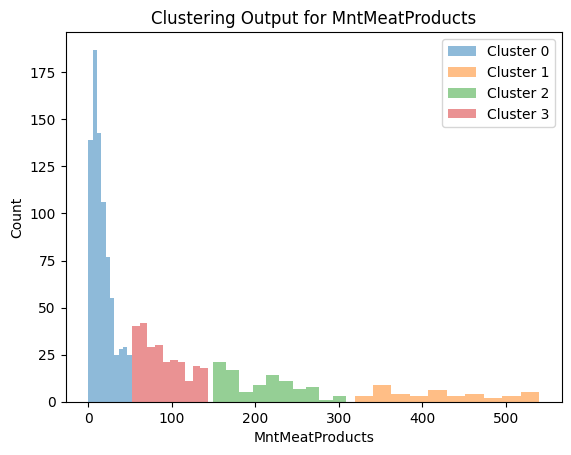

Silhouette coefficient for MntMeatProducts: 0.7052442347998612



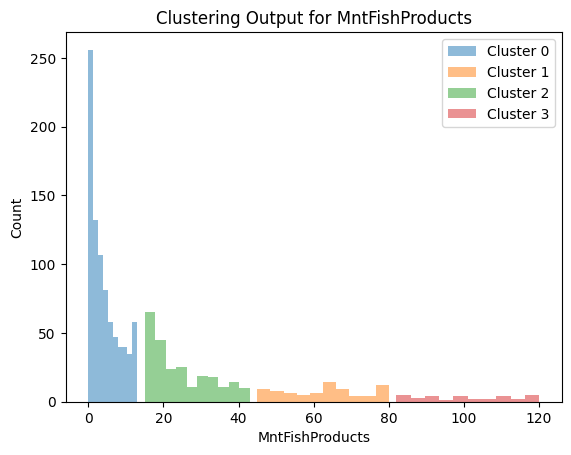

Silhouette coefficient for MntFishProducts: 0.6834098350592557



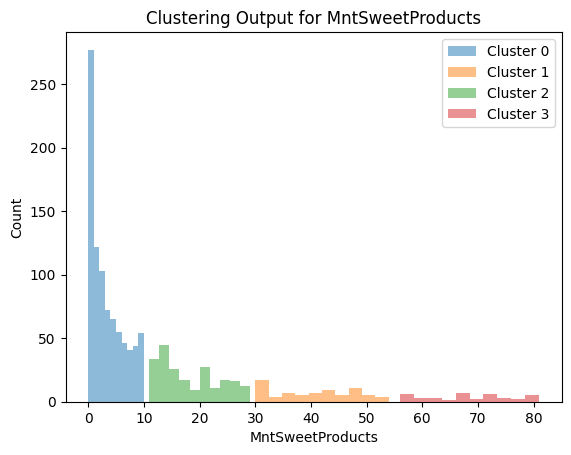

Silhouette coefficient for MntSweetProducts: 0.6922094953008741



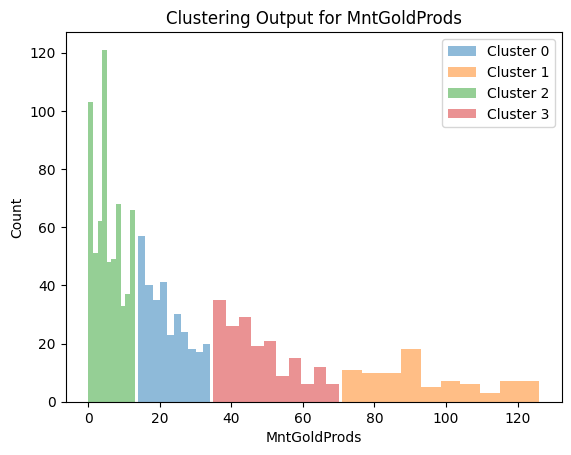

Silhouette coefficient for MntGoldProds: 0.6094761181687612



In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


selected_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']


for product in selected_columns:

    X = marketing_campaign_df[[product]].copy()

    # Perform data normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  # clusters are High, Frequent, Low, Non
    X[product + '_cluster'] = kmeans.fit_predict(X_normalized)

    for i in range(4):
        cluster_data = X[X[product + '_cluster'] == i][product]
        plt.hist(cluster_data, bins=10, alpha=0.5, label=f'Cluster {i}')

    plt.xlabel(product)
    plt.ylabel('Count')
    plt.title(f'Clustering Output for {product}')
    plt.legend()
    plt.show()

    # Calculate the Silhouette coefficient for the clustering results
    silhouette_avg = silhouette_score(X_normalized, kmeans.labels_)
    print(f"Silhouette coefficient for {product}: {silhouette_avg}\n")


## Find frequent patterns

In [48]:
def find_frequent_patterns(df, min_supports=[0.02, 0.05, 0.2, 0.4, 0.5, 0.6], min_confidences=[0.02,0.05, 0.2, 0.4, 0.5, 0.6]):

    results = pd.DataFrame(columns=['Min Support', 'Min Confidence', 'Itemsets'])

    for min_support in min_supports:
        for min_confidence in min_confidences:
            itemsets_list = []
            frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True, max_len=3)
            itemsets = frequent_itemsets[frequent_itemsets['support'] >= min_confidence]
            itemsets_list.append(itemsets)

            concatenated_itemsets = pd.concat(itemsets_list)
            results = pd.concat(
                [
                    results,
                    pd.DataFrame(
                        {"Min Support": min_support, "Min Confidence": min_confidence, "Itemsets": [concatenated_itemsets]},
                        dtype=object,
                    ),
                ],
                ignore_index=True,
            )

    return results

In [49]:
acceptedCmp_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

acceptedCmp_df = marketing_campaign_df[acceptedCmp_columns].copy()

freq_patterns = find_frequent_patterns(acceptedCmp_df)

for _, row in freq_patterns.iterrows():
    min_support = row['Min Support']
    min_confidence = row['Min Confidence']
    itemsets = row['Itemsets']
    print(f"Min Support: {min_support}, Min Confidence: {min_confidence}")
    print(itemsets)
    print("---------------------------------------\n")

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/apriori.py:158: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]])
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/apriori.py:158: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]])
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/apriori.py:158: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]])
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/apriori.py:15

Min Support: 0.02, Min Confidence: 0.02
Empty DataFrame
Columns: [support, itemsets]
Index: []
---------------------------------------

Min Support: 0.02, Min Confidence: 0.05
Empty DataFrame
Columns: [support, itemsets]
Index: []
---------------------------------------

Min Support: 0.02, Min Confidence: 0.2
Empty DataFrame
Columns: [support, itemsets]
Index: []
---------------------------------------

Min Support: 0.02, Min Confidence: 0.4
Empty DataFrame
Columns: [support, itemsets]
Index: []
---------------------------------------

Min Support: 0.02, Min Confidence: 0.5
Empty DataFrame
Columns: [support, itemsets]
Index: []
---------------------------------------

Min Support: 0.02, Min Confidence: 0.6
Empty DataFrame
Columns: [support, itemsets]
Index: []
---------------------------------------

Min Support: 0.05, Min Confidence: 0.02
Empty DataFrame
Columns: [support, itemsets]
Index: []
---------------------------------------

Min Support: 0.05, Min Confidence: 0.05
Empty DataFr

In [50]:
def preprocess_data(df):
    # Convert values to binary (0 or 1)
    df = df.applymap(lambda x: 1 if x > 0 else 0)
    return df

relevant_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df = marketing_campaign_df[relevant_columns].copy()
df = preprocess_data(df)
freq_patterns = find_frequent_patterns(df, min_supports=[0.5, 0.8, 0.9], min_confidences=[0.5, 0.8, 0.9])
for _, row in freq_patterns.iterrows():
    min_support = row['Min Support']
    min_confidence = row['Min Confidence']
    itemsets = row['Itemsets']
    print(f"Min Support: {min_support}, Min Confidence: {min_confidence}")
    print(itemsets)
    print("---------------------------------------\n")

Min Support: 0.5, Min Confidence: 0.5
     support                                           itemsets
0   0.990041                                         (MntWines)
1   0.775934                                        (MntFruits)
2   0.999170                                  (MntMeatProducts)
3   0.788382                                  (MntFishProducts)
4   0.770124                                 (MntSweetProducts)
5   0.966805                                     (MntGoldProds)
6   0.769295                              (MntFruits, MntWines)
7   0.990041                        (MntWines, MntMeatProducts)
8   0.778423                        (MntFishProducts, MntWines)
9   0.760996                       (MntSweetProducts, MntWines)
10  0.956846                           (MntWines, MntGoldProds)
11  0.775934                       (MntFruits, MntMeatProducts)
12  0.673859                       (MntFruits, MntFishProducts)
13  0.661411                      (MntFruits, MntSweetProducts)
14

## Supervised Learning

### Classification for predicting user participation in future campaigns

In [51]:
# Relevant columns for classification
relevant_columns = ['Response', 'Income', 'Kidhome', 'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4',
                    'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2']

# Extract the relevant columns from the dataset
df = marketing_campaign_df[relevant_columns].copy()

# Split the dataset into features (X) and target variable (y)
X = df.drop('Response', axis=1)
y = df['Response']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using Standardization
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the normalized data into training and testing sets
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

#### Naive Bayesian Classification and Decision Trees (without Normalization)

In [52]:
# Bayes Classification
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
nb_predictions = nb_classifier.predict(X_test)

# Decision Tree Classification
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)

# Evaluate the classifiers
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions)
nb_recall = recall_score(y_test, nb_predictions)
nb_f1 = f1_score(y_test, nb_predictions)

dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision = precision_score(y_test, dt_predictions)
dt_recall = recall_score(y_test, dt_predictions)
dt_f1 = f1_score(y_test, dt_predictions)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

In [53]:
# Print the evaluation metrics
print("Bayes Classification Metrics:")
print(f"Accuracy: {nb_accuracy}")
print(f"Precision: {nb_precision}")
print(f"Recall: {nb_recall}")
print(f"F1-Score: {nb_f1}")
print("----------------------------------------")
print("Decision Tree Classification Metrics:")
print(f"Accuracy: {dt_accuracy}")
print(f"Precision: {dt_precision}")
print(f"Recall: {dt_recall}")
print(f"F1-Score: {dt_f1}")

Bayes Classification Metrics:
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
----------------------------------------
Decision Tree Classification Metrics:
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


#### Naive Bayesian Classification and Decision Trees (with Normalization)

In [54]:
# Bayes Classification
nb_classifier = GaussianNB()
nb_classifier.fit(X_norm_train, y_norm_train)
nb_predictions = nb_classifier.predict(X_norm_test)

# Decision Tree Classification
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_norm_train, y_norm_train)
dt_predictions = dt_classifier.predict(X_norm_test)

# Evaluate the classifiers
nb_accuracy = accuracy_score(y_norm_test, nb_predictions)
nb_precision = precision_score(y_norm_test, nb_predictions)
nb_recall = recall_score(y_norm_test, nb_predictions)
nb_f1 = f1_score(y_norm_test, nb_predictions)

dt_accuracy = accuracy_score(y_norm_test, dt_predictions)
dt_precision = precision_score(y_norm_test, dt_predictions)
dt_recall = recall_score(y_norm_test, dt_predictions)
dt_f1 = f1_score(y_norm_test, dt_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

In [55]:
# Print the evaluation metrics
print("Bayes Classification Metrics:")
print(f"Accuracy: {nb_accuracy}")
print(f"Precision: {nb_precision}")
print(f"Recall: {nb_recall}")
print(f"F1-Score: {nb_f1}")
print("----------------------------------------")
print("Decision Tree Classification Metrics:")
print(f"Accuracy: {dt_accuracy}")
print(f"Precision: {dt_precision}")
print(f"Recall: {dt_recall}")
print(f"F1-Score: {dt_f1}")

Bayes Classification Metrics:
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
----------------------------------------
Decision Tree Classification Metrics:
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


#### Random Forest Classifier

In [56]:
# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the classification metrics
print("Random Forest Classification Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Random Forest Classification Metrics:
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


### Classification for predicting future user purchases from the company

In [57]:
# Relevant columns for classification
relevant_columns = ['Response', 'Recency', 'Complain', 'AcceptedCmp3', 'AcceptedCmp4',
                    'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2']

# Extract the relevant columns from the dataset
df = marketing_campaign_df[relevant_columns].copy()

# Split the dataset into features (X) and target variable (y)
X = df.drop('Response', axis=1)
y = df['Response']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using Standardization
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the normalized data into training and testing sets
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

#### Naive Bayesian Classification and Decision Trees (without Normalization)

In [58]:
# Bayes Classification
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
y_pred_nb = naive_bayes.predict(X_test)

# Decision Tree Classification
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred_dt = decision_tree.predict(X_test)

# Evaluate Bayes Classification
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_score_nb = f1_score(y_test, y_pred_nb)

# Evaluate Decision Tree Classification
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_score_dt = f1_score(y_test, y_pred_dt)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

In [59]:
print("Bayes Classification Metrics:")
print(f"Accuracy: {accuracy_nb}")
print(f"Precision: {precision_nb}")
print(f"Recall: {recall_nb}")
print(f"F1-Score: {f1_score_nb}")
print("----------------------------------------")
print("Decision Tree Classification Metrics:")
print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1-Score: {f1_score_dt}")

Bayes Classification Metrics:
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
----------------------------------------
Decision Tree Classification Metrics:
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


#### Naive Bayesian Classification and Decision Trees (with Normalization)

In [60]:
# Bayes Classification
nb_classifier = GaussianNB()
nb_classifier.fit(X_norm_train, y_norm_train)
nb_predictions = nb_classifier.predict(X_norm_test)

# Decision Tree Classification
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_norm_train, y_norm_train)
dt_predictions = dt_classifier.predict(X_norm_test)

# Evaluate the classifiers
accuracy_nb = accuracy_score(y_norm_test, nb_predictions)
precision_nb = precision_score(y_norm_test, nb_predictions)
recall_nb = recall_score(y_norm_test, nb_predictions)
f1_score_nb = f1_score(y_norm_test, nb_predictions)

accuracy_dt = accuracy_score(y_norm_test, dt_predictions)
precision_dt = precision_score(y_norm_test, dt_predictions)
recall_dt = recall_score(y_norm_test, dt_predictions)
f1_score_dt = f1_score(y_norm_test, dt_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

In [61]:
print("Bayes Classification Metrics:")
print(f"Accuracy: {accuracy_nb}")
print(f"Precision: {precision_nb}")
print(f"Recall: {recall_nb}")
print(f"F1-Score: {f1_score_nb}")
print("----------------------------------------")

print("Decision Tree Classification Metrics:")
print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1-Score: {f1_score_dt}")

Bayes Classification Metrics:
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
----------------------------------------
Decision Tree Classification Metrics:
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


#### Random Forest Classifier

In [62]:
# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the classification metrics
print("Random Forest Classification Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Random Forest Classification Metrics:
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


### Relation between level of education and the way customers buy from the store

#### Use association rules

In [63]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Select relevant columns
relevant_columns = ['Education', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df = marketing_campaign_df[relevant_columns].copy()

# Perform one-hot encoding on the 'Education' column
df_encoded = pd.get_dummies(df, columns=['Education'])

# Convert the numeric columns to binary columns for association rule mining
def convert_to_binary(x):
    if x > 0:
        return 1
    else:
        return 0

df_encoded['NumWebPurchases'] = df_encoded['NumWebPurchases'].apply(convert_to_binary)
df_encoded['NumCatalogPurchases'] = df_encoded['NumCatalogPurchases'].apply(convert_to_binary)
df_encoded['NumStorePurchases'] = df_encoded['NumStorePurchases'].apply(convert_to_binary)

# Perform association rule mining
frequent_itemsets = apriori(df_encoded, min_support=0.3, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.972614,(NumWebPurchases)
1,0.568465,(NumCatalogPurchases)
2,0.999170,(NumStorePurchases)
3,0.480498,(Education_Graduation)
4,0.563485,"(NumCatalogPurchases, NumWebPurchases)"
5,0.971784,"(NumStorePurchases, NumWebPurchases)"
6,0.464730,"(Education_Graduation, NumWebPurchases)"
7,0.568465,"(NumCatalogPurchases, NumStorePurchases)"
8,0.479668,"(NumStorePurchases, Education_Graduation)"
9,0.563485,"(NumCatalogPurchases, NumStorePurchases, NumWe..."


In [64]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
selected_columns = rules[['support', 'confidence', 'antecedents', 'consequents']]

selected_columns['antecedents'] = selected_columns['antecedents'].apply(lambda x: tuple(x))
selected_columns['consequents'] = selected_columns['consequents'].apply(lambda x: tuple(x))
selected_columns['support'] = selected_columns['support'].apply(lambda x: round(x, 2))
selected_columns['confidence'] = selected_columns['confidence'].apply(lambda x: round(x, 2))

selected_columns.to_csv('association_rules.csv', index=False)

<ipython-input-64-26b4fed75949>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns['antecedents'] = selected_columns['antecedents'].apply(lambda x: tuple(x))
<ipython-input-64-26b4fed75949>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns['consequents'] = selected_columns['consequents'].apply(lambda x: tuple(x))
<ipython-input-64-26b4fed75949>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

#### Use word cloud

In [65]:
relevant_columns = ['Education']
df = marketing_campaign_df[relevant_columns].copy()

# Convert the numeric columns to binary columns
def convert_to_binary(x):
    if x > 0:
        return 1
    else:
        return 0

df['DoWebPurchases'] = marketing_campaign_df['NumWebPurchases'].apply(convert_to_binary)
df['DoCatalogPurchases'] = marketing_campaign_df['NumCatalogPurchases'].apply(convert_to_binary)
df['DoStorePurchases'] = marketing_campaign_df['NumStorePurchases'].apply(convert_to_binary)

In [66]:
df.head()

,Education,DoWebPurchases,DoCatalogPurchases,DoStorePurchases
1,Graduation,1,1,1
2,Graduation,1,1,1
3,Graduation,1,0,1
4,PhD,1,1,1
5,Master,1,1,1


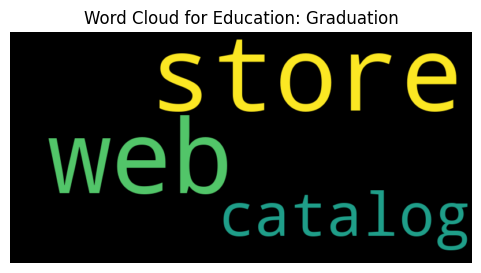

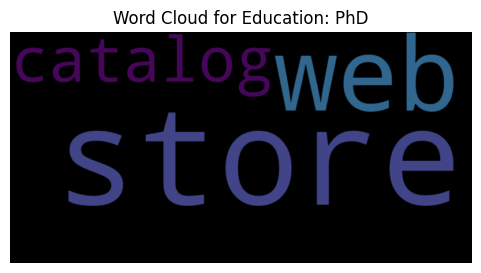

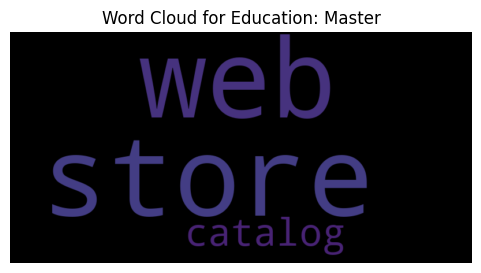

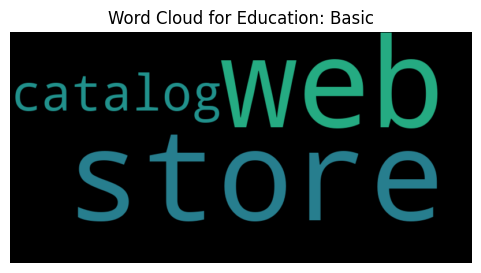

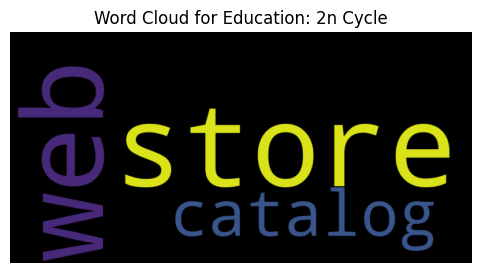

In [67]:
# Step 1: Iterate over each unique education value
for education_value in df['Education'].unique():
    # Step 2: Filter the data by education value
    filtered_data = df[df['Education'] == education_value]

    # Step 3: Count the occurrences of each purchase type for the education group
    purchase_counts = {
        'web': filtered_data['DoWebPurchases'].sum(),
        'catalog': filtered_data['DoCatalogPurchases'].sum(),
        'store': filtered_data['DoStorePurchases'].sum()
    }

    # Create a WordCloud object with the purchase counts as frequencies
    wordcloud = WordCloud(width=800, height=400)

    # Generate the word cloud
    wordcloud.generate_from_frequencies(purchase_counts)

    # Display the word cloud
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Education: {education_value}')
    plt.axis('off')
    plt.show()
